# Grover's Quantum Search Algorithm Tests

This Python notebook provides some practical tests and visualizations of the Grover Search algorithm. All tests have been executed on the **OpenQASM Simulator** (https://sooluthomas.github.io/testTranslation/terra/executing_quantum_programs.html#executing-quantum-programs) offered by Qiskit, but any other backend (simulator or real quantum machine) can be used to run these tests.

In [ ]:
from qiskit import *
from qiskit.visualization import plot_histogram

from random import getrandbits, randint

from binary_cost_function import *
from custom_gas import *
from num_base_converter import *

#### Cost function:

First we define a binary cost function. Our chosen function for testing will be:

$$
6 \cdot \left[\mathtt{X101}\right] + 3 \cdot \left[\mathtt{XXX0}\right] + 7 \cdot \left[\mathtt{X011}\right] - 2 \cdot \left[\mathtt{XXX1}\right] - 2 \cdot \left[\mathtt{01X1}\right],
$$

where $\mathtt{X}, \mathtt{0}$ and $\mathtt{1}$ denote free, 0 and 1 required bit values, respectively. That is, the cost function is:

$$
\mathcal{C}(x) = 6 \cdot x_2(1-x_3)x_4 + 3 \cdot (1-x_4) + 7 \cdot (1-x_2)x_3x_4 - 2 \cdot x_4 - 2 \cdot (1-x_1)x_2x_4.
$$

The clauses and values can be added, removed or changed as desired.

In [ ]:
bcf_test = BinaryCostFunction(4)

clauses = [
    BinaryClause("X101"),
    BinaryClause("XXX0"),
    BinaryClause("X011"),
    BinaryClause("XXX1"),
    BinaryClause("01X1")
]

values = [6, 3, 7, -2, -2]

for clause, value in zip(clauses, values):
    bcf_test.add_clause(clause, value)
    
print(bcf_test)

#### Circuit parameters:

  - `n`: Number of qubits for the first regiter, which is the number of bits of the binary cost function.
  - `m`: Number of qubits for the second register, for storing the evaluated binary cost function.
  - `bcf`: Binary cost function to optimize.

Recall that the $m$ will allow us to store integer values on the interval $\left[-2^{m-1}, 2^{m-1}-1\right]$. With our cost function, the worst cases would be when only the positive (or negative) value clauses are satisfied, giving us upper and lower bounds of its image: $\left[-4, 16\right]$. For this reason, we will choose

$$
m = \lceil \log_{2}(\max(\lvert -4\rvert\ , \lvert 16 \rvert +1)) \rceil + 1 = \lceil \log_{2}(17) \rceil + 1 \approx \lceil 4.087463 \rceil + 1 = 6
$$

to allow for values in the range $\left[-32, 31\right]$. We now add an extra qubit to account for the threshold, so that there is no overflow/underflow when extreme values of the threshold are set, giving out a final value of $m = 7$.

Any other binary cost function with adequate $n, m$ parameters can be tested.

In [ ]:
bcf = bcf_test
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2

print("n = ", n, ", m = ", m, sep = "")
print("bcf: ")
print(bcf)

#### Binary clause circuit implementation and tests:

Example circuit for the binary clause $\left[\mathtt{X010}\right]$ with value 6.

In [ ]:
bc_circuit(m, BinaryClause("X010"), 6).draw(output = "mpl")

We test the gate by codifying the string $\left[\mathtt{0010}\right]$ on the `ctrl` register, which satisfies the clause. By adding other $X$ gates on other qubits of the `ctrl` register we can test other strings.

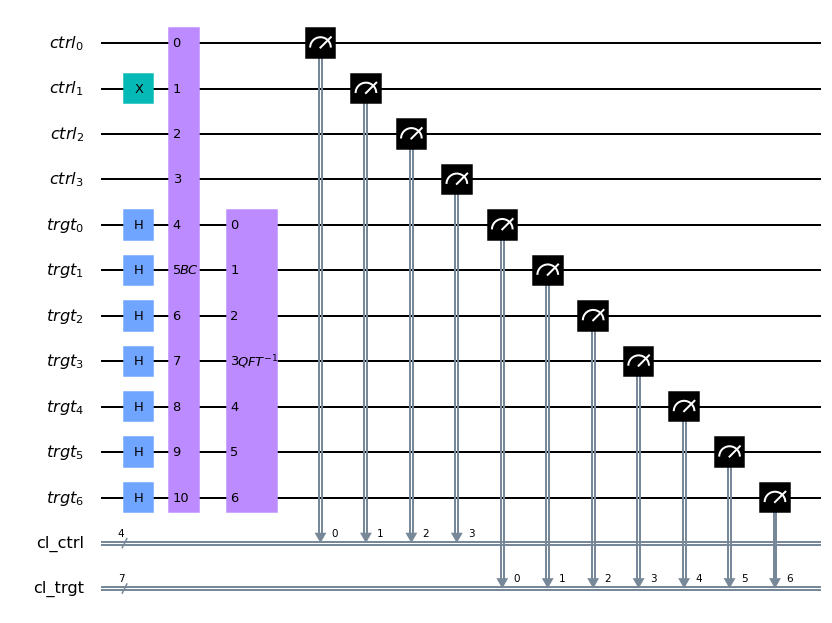

In [5]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

qc.x(qr_ctrl[1])
qc.h(qr_trgt[:])

qc.append(bc_circuit(m, BinaryClause("X010"), 6).to_gate(label = "$BC$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

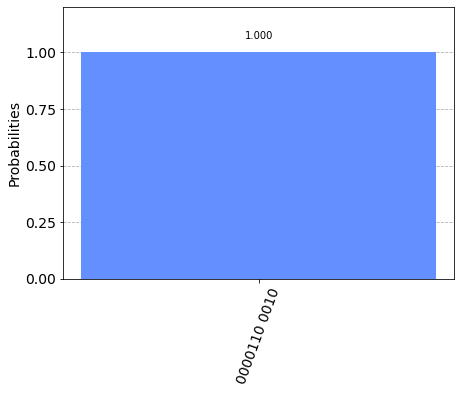

In [6]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 128)
counts = job.result().get_counts()
plot_histogram(counts)

Circuit for the binary cost function.

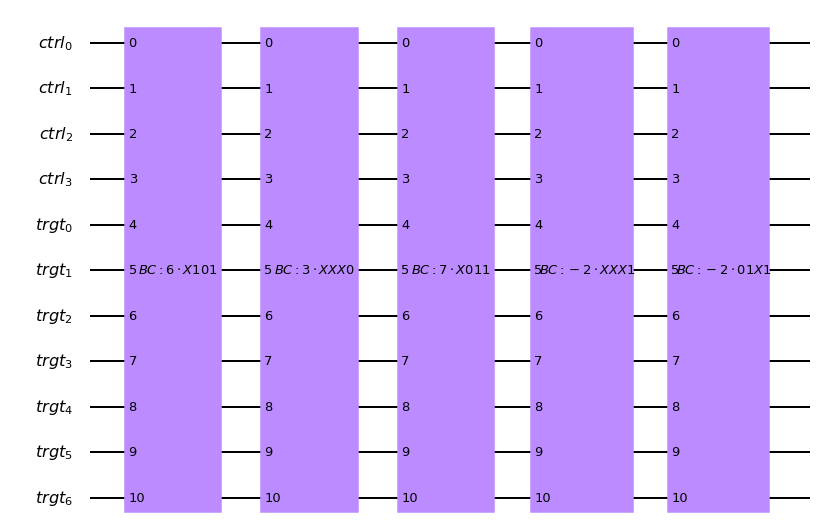

In [7]:
bcf_circuit(m, bcf).draw(output = "mpl")

We repeat the same test but now we evaluate the entire cost function on the string $\left[\mathtt{0010}\right]$. The expected value with this is string is:

In [8]:
bcf.evaluate("0010")

3

Any other string can be tested to check that the circuit works.

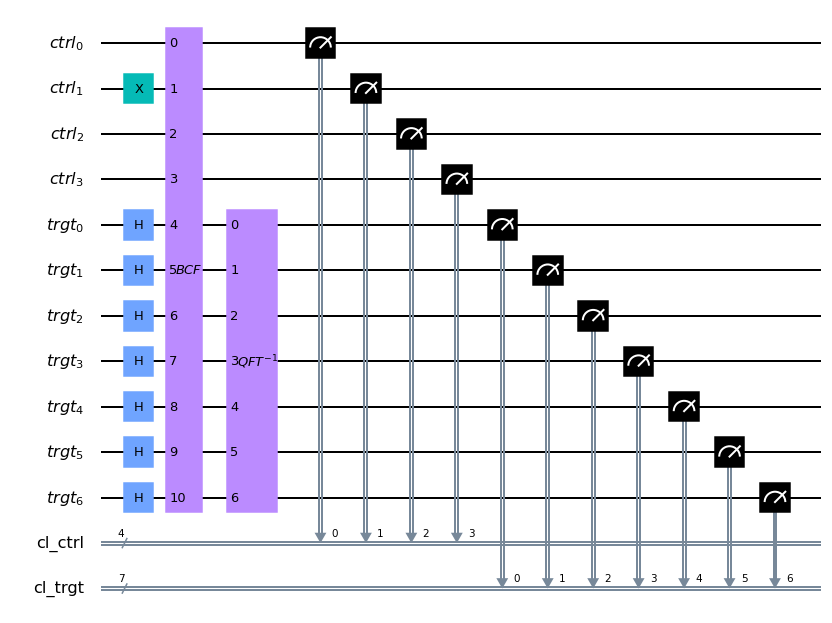

In [9]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

qc.x(qr_ctrl[1])
qc.h(qr_trgt[:])

qc.append(bcf_circuit(m, bcf).to_gate(label = "$BCF$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

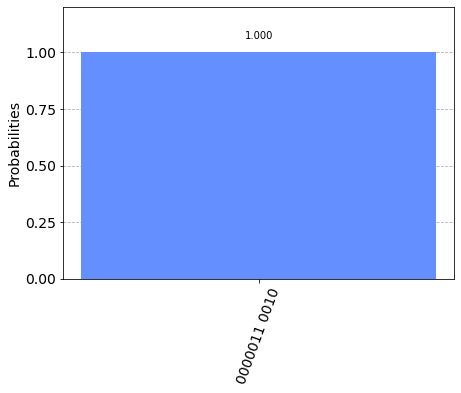

In [10]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 128)
counts = job.result().get_counts()
plot_histogram(counts)

#### Operator $A$, Iterator $G$ and final circuit:

State preparator and function evaluator $A$.

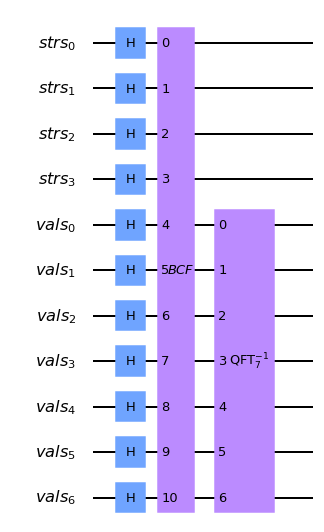

In [11]:
A_circuit(m, bcf).draw(output = "mpl")

Grover iterator $G = A D A^{-1} O$.

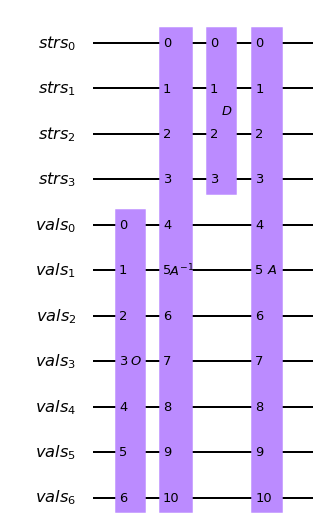

In [12]:
G_circuit(m, bcf).draw(output = "mpl")

The complete Grover Search circuit, which will be run iteratively with varying values of `threshold` and number of iteraitons `r`.

The `threshold` is implemented by adding an additional clause with bits $\left[\mathtt{X \dots X}\right]$ and value $-y$ where $y$ is the `threshold` for the current iteration.

This example shows the circuit with $y = 4$, $r = 3$.

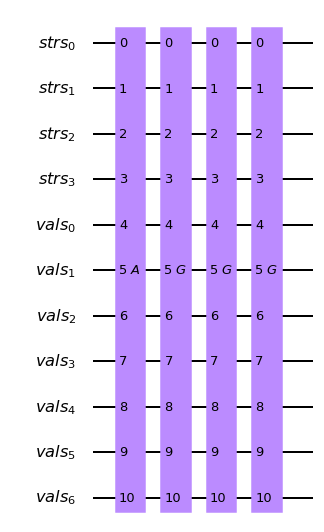

In [13]:
GAS_circuit(m, bcf, 4, 3).draw(output = "mpl")

#### Test run:

We now perform a test run of Grover Search with the following cost function:

$$
\mathcal{C}(x) = -1 \cdot \left[\mathtt{111111}\right].
$$

In [22]:
bcf_test_2 = BinaryCostFunction(8)

clauses = [
    BinaryClause("1" * 8)
]

values = [-1]

for clause, value in zip(clauses, values):
    bcf_test_2.add_clause(clause, value)
    
print(bcf_test_2)

-1 * 11111111



We know the function has $2^{8} = 256$ possible options to try out, and only one of them will be optimal when `threshold = 0`, meaning the number of times the iterator $G$ must be applied is:

$$
r = \left \lfloor \frac{\pi}{4} \frac{1}{\arcsin{\left(\sqrt{\frac{1}{2^{8}}}\right)}} \right \rfloor = 12.
$$

In [24]:
bcf = bcf_test_2
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2
r = 12

print("n = ", n, ", m = ", m, ", r = ", r, sep = "")
print("bcf: ")
print(bcf)

n = 8, m = 2, r = 12
bcf: 
-1 * 11111111



Run the next cells to execute the test.

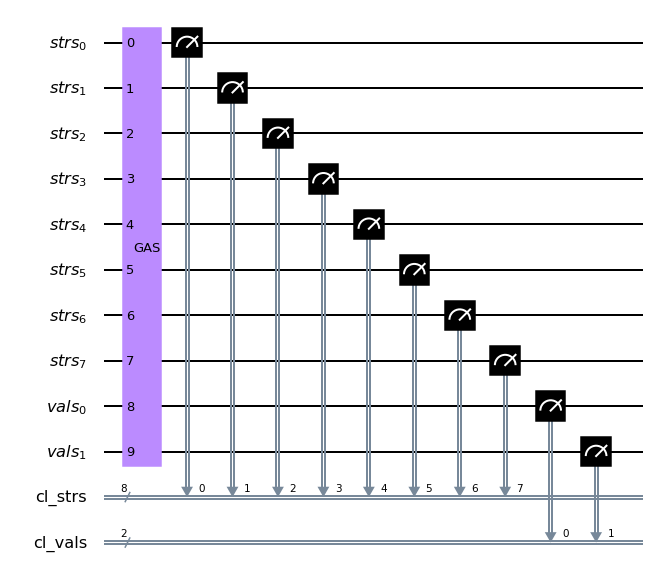

In [25]:
qc = QuantumCircuit()

qr_strs = QuantumRegister(n, "strs")
qr_vals = QuantumRegister(m, "vals")
cr_strs = ClassicalRegister(n, "cl_strs")
cr_vals = ClassicalRegister(m, "cl_vals")
qc.add_register(qr_strs)
qc.add_register(qr_vals)
qc.add_register(cr_strs)
qc.add_register(cr_vals)

GAS_gate = GAS_circuit(m, bcf, 0, r).to_gate(label = "GAS")
qc.append(GAS_gate, qr_strs[0:n] + qr_vals[0:m])

qc.measure(qr_strs, cr_strs)
qc.measure(qr_vals, cr_vals)

qc.draw(output = "mpl")

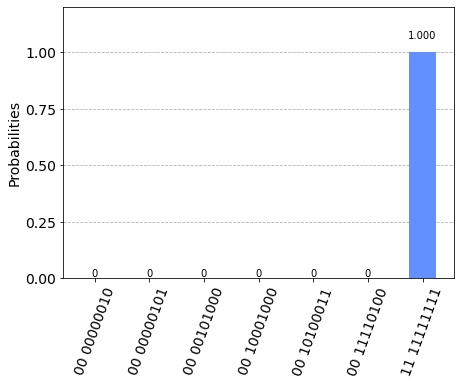

In [31]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 100000)
counts = job.result().get_counts()

plot_histogram(counts)

We can appreciate that the returned answer is almost surely the optimum string $\mathtt{11111111}$ and optimum value $-1$ with only $12$ applications of the iterator $G$. A classical computer would have to evaluate the cost function an average of $2^{n-1} = 128$ times to find the optimum string. Also, as $n$ grows, the probability of reading the correct answer also increases. The tests can be performed with any cost function that has any number of optimal and possible values by choosing the adequate parameters.

As $n$ grows, the times a classical function will have to evaluate the cost function grows in order $O(2^n)$, while the number of applications of the iterator $G$ grows in order $O(2^{\frac{n}{2}})$.